<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries-and-load-the-data" data-toc-modified-id="Import-libraries-and-load-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries and load the data</a></span><ul class="toc-item"><li><span><a href="#Train-and-Test-Splits" data-toc-modified-id="Train-and-Test-Splits-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train and Test Splits</a></span></li><li><span><a href="#1.2-Scaler" data-toc-modified-id="1.2-Scaler-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>1.2 Scaler</a></span></li></ul></li><li><span><a href="#2.-Modeling" data-toc-modified-id="2.-Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Modeling</a></span><ul class="toc-item"><li><span><a href="#Baseline-model---Dummy-regressor" data-toc-modified-id="Baseline-model---Dummy-regressor-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Baseline model - Dummy regressor</a></span></li><li><span><a href="#Model_1:-Linear-Regression-Model" data-toc-modified-id="Model_1:-Linear-Regression-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model_1: Linear Regression Model</a></span><ul class="toc-item"><li><span><a href="#Make-predictions-on-both-train-and-test-splits" data-toc-modified-id="Make-predictions-on-both-train-and-test-splits-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Make predictions on both train and test splits</a></span></li><li><span><a href="#Assess-the-model-performance" data-toc-modified-id="Assess-the-model-performance-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Assess the model performance</a></span></li><li><span><a href="#Hyperparameter-search-using-random-GridSearchCV" data-toc-modified-id="Hyperparameter-search-using-random-GridSearchCV-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Hyperparameter search using random GridSearchCV</a></span></li></ul></li><li><span><a href="#Random-forest-regressor" data-toc-modified-id="Random-forest-regressor-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random forest regressor</a></span></li><li><span><a href="#Data-Quantity-Assessment" data-toc-modified-id="Data-Quantity-Assessment-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Data Quantity Assessment</a></span></li><li><span><a href="#Save-Final-Model" data-toc-modified-id="Save-Final-Model-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Save Final Model</a></span></li></ul></li><li><span><a href="#Summary-and-further-analysis" data-toc-modified-id="Summary-and-further-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary and further analysis</a></span></li></ul></div>

## Import libraries and load the data

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

import scipy.stats as stats
from scipy.stats import norm

from sklearn import __version__ as sklearn_version
from library.sb_utils import save_file
%matplotlib inline

sns.set_style('whitegrid') 
# plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

In [62]:
df = pd.read_csv('./Data/clean_data.csv')
df.head()

,Ship Mode,Segment,State,Region,Category,Sales,Quantity,Discount,Profit,Waiting_Days,avg_items_per_100kcapita
0,Standard Class,Consumer,Michigan,Central,Office Supplies,496.860,7,0.0,24.8430,6,6.0
1,First Class,Consumer,California,West,Technology,494.376,3,0.2,49.4376,2,14.0
2,Standard Class,Consumer,Pennsylvania,East,Furniture,492.835,5,0.3,-14.0810,6,11.0
3,Standard Class,Home Office,Virginia,South,Office Supplies,489.920,8,0.0,0.0000,5,6.0
4,Standard Class,Consumer,Texas,Central,Furniture,489.230,2,0.3,41.9340,7,9.0


In [63]:
print(df.shape)
df.info()

(7465, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7465 entries, 0 to 7464
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ship Mode                 7465 non-null   object 
 1   Segment                   7465 non-null   object 
 2   State                     7465 non-null   object 
 3   Region                    7465 non-null   object 
 4   Category                  7465 non-null   object 
 5   Sales                     7465 non-null   float64
 6   Quantity                  7465 non-null   int64  
 7   Discount                  7465 non-null   float64
 8   Profit                    7465 non-null   float64
 9   Waiting_Days              7465 non-null   int64  
 10  avg_items_per_100kcapita  7457 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 641.6+ KB


## Data Preprocessing

### Encoding categorical features

In [68]:
# Categorical to Quantitative relationship
categorical_features = [i for i in df.columns if df.dtypes[i] == "object"]
categorical_features.remove("State")
categorical_features

['Ship Mode', 'Segment', 'Region', 'Category']

In [94]:
# labeling encoding the categorical features
for cat in categorical_features:
    label = LabelEncoder()
    df[cat] = label.fit_transform(df[cat])
df[cat].dropna(inplace=True)

In [98]:
# fill in missing values
df['avg_items_per_100kcapita'].isna().sum()

8

In [99]:
items_mean = df['avg_items_per_100kcapita'].mean()

df.loc[df['avg_items_per_100kcapita'].isnull(), 'avg_items_per_100kcapita'] = items_mean

In [111]:
df.head()

,Ship Mode,Segment,State,Region,Category,Sales,Quantity,Discount,Profit,Waiting_Days,avg_items_per_100kcapita
0,3,0,Michigan,0,1,496.860,7,0.0,24.8430,6,6.0
1,0,0,California,3,2,494.376,3,0.2,49.4376,2,14.0
2,3,0,Pennsylvania,1,0,492.835,5,0.3,-14.0810,6,11.0
3,3,2,Virginia,2,1,489.920,8,0.0,0.0000,5,6.0
4,3,0,Texas,0,0,489.230,2,0.3,41.9340,7,9.0


In [113]:
# df.info()

### Study target variable 

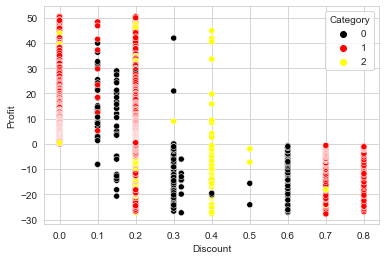

In [116]:
hue_color = {0: 'black', 1:'red', 2:'yellow'}
sns.scatterplot(x='Discount', y='Profit', data=df, hue='Category', palette=hue_color);
# observation:  a number of large percentage discounts ran on products in category 1.

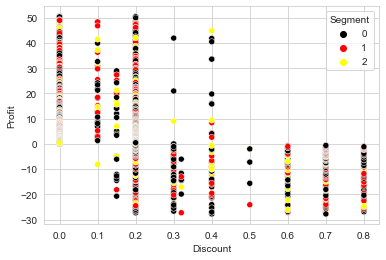

In [121]:
hue_color = {0: 'black', 1:'red', 2:'yellow'}
sns.scatterplot(x='Discount', y='Profit', data=df, hue='Segment', palette=hue_color);
# observation:  

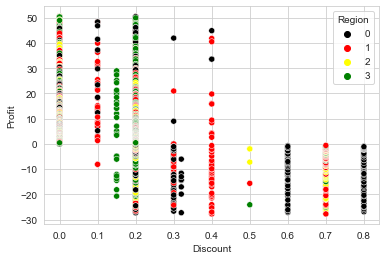

In [122]:
hue_color = {0: 'black', 1:'red', 2:'yellow', 3:'green'}
sns.scatterplot(x='Discount', y='Profit', data=df, hue='Region', palette=hue_color);
# observation:  a number of large percentage discounts ran on products in region 0 & 1.

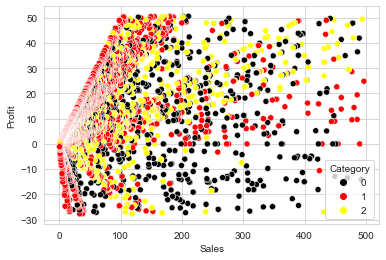

In [124]:
sns.scatterplot(x='Sales', y='Profit', data=df, hue='Category', palette=hue_color);

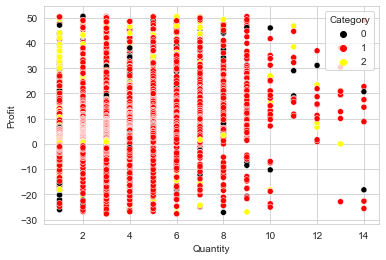

In [126]:
sns.scatterplot(x='Quantity', y='Profit', data=df, hue='Category', palette=hue_color);

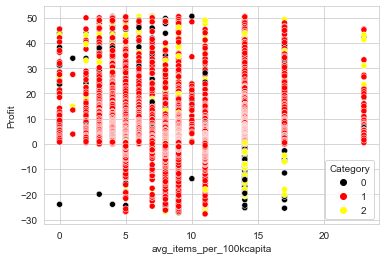

In [129]:
sns.scatterplot(x='avg_items_per_100kcapita', y='Profit', data=df, hue='Category', palette=hue_color);


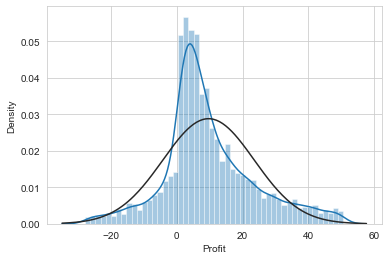

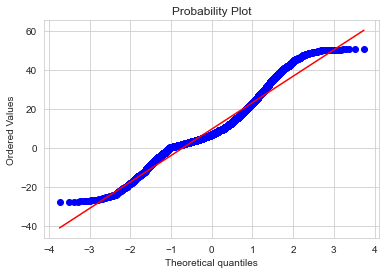

In [132]:
#histogram and normal probability plot
sns.distplot(df['Profit'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['Profit'], plot=plt)

# the distribution is slightly being pulled to the right due to a few large profit (ranging from 40 to 50). 
# it is a slightly positively skewed distribution.
# the distribution has a high peak: the mode of the distribution is the most peaked point on the graph, which is between 0 ~ 10, indicating the most frequent profits over all states.

# Our QQ-plot shows that the distribtuion of 'profit' is close to the normal distribtuion. no need do log tranform in this case.

### Train and Test Splits

In order to fit the models on the data, I first define the ‘X’ variable (independent variable) and the ‘Y’ variable (dependent variable). After defining the variables, split the data into a train set and test set using the ‘train_test_split’ function by scikit-learn. 

In [138]:
# to avoid multi-colinearity, drop columns 'Same_day_ratio', 'Consumer_ratio','Furniture_ratio'
# load most of the public parts of statsmodels, make functions & classes available within 1 or 2 levels
import statsmodels.api as sm 
X = df.drop(['State', 'Profit'], axis=1)
X = sm.add_constant(X)

y = df['Profit']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  
print(X_train.shape, X_test.shape)
train_columns = X_train.columns

(5225, 10) (2240, 10)


In [103]:
train_columns

Index(['Ship Mode', 'Segment', 'Region', 'Category', 'Sales', 'Quantity',
       'Discount', 'Waiting_Days', 'avg_items_per_100kcapita'],
      dtype='object')

### 1.2 Scaler

In [104]:
#Call StandardScaler method on `X_tr` to fit the scaler;
# use `transform()` method to apply the scaling to both the train and test split.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2. Modeling

To build and train five different types of linear regression models:
    - OLS model
    - Lasso regression model
    - Ridge regression model
    - Elastic Net regression model
    - Random forest regression model
    
    The linear regression model assumes a linear relationship between the input and output variables. If this relationship is present, we use Pearson correlation coefficients to measure the direction and strength of the linear relationship between two variables, and use evaluation metrics such as mean square error to measure the predictive power of the linear regression model. 

### Dummy regressor

In [105]:
# gain a baseline idea of performance by simply taking the average
train_mean = y_train.mean()
train_mean

9.662319999999994

In [106]:
# Fit the skilearn dummy regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[9.66232]])

In [107]:
#prepare dictionary to store results
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

In [108]:
def make_model(model, x_train, x_test, y_train, y_test, title):
    
    model.fit(x_train, y_train)
    cv_5 = cross_val_score(model, x_train, y_train, cv=5)
    r2 = round(cv_5.mean()*100,2)
    
    y_test_pred = model.predict(x_test)

    residuals = y_test - y_test_pred

    fig = plt.figure(figsize=(10,5))
    plt.scatter(y_test_pred, residuals)
    plt.show();
    
    # Calculate our errors
    mae = round(mean_absolute_error(y_test, y_test_pred), 2)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)

    # append our results to our lists
    models['Models'].append(title)
    models['r2'].append(r2)
    models['mae'].append(mae)
    models['rmse'].append(rmse)

    print("R2: ", r2, "\nMAE: ", mae, "\nRMSE: ", rmse, "\n{} predictors used for this model".format(X_train.shape[1]))

###  Model_1: Linear Regression Model

run a base model with no cross-validation or specific feature selection with ALL possible features

In [143]:
# create the third model, it is the same algorithm, just different inputs
model = sm.OLS(y_train, X_train) .fit()

# Evaluate the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     388.9
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        13:52:55   Log-Likelihood:                -19788.
No. Observations:                5225   AIC:                         3.960e+04
Df Residuals:                    5215   BIC:                         3.966e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

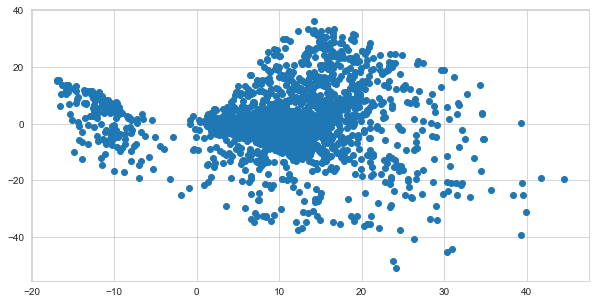

R2:  39.45 
MAE:  7.85 
RMSE:  11.19 
9 predictors used for this model


In [110]:
make_model(lm, X_train, X_test, y_train, y_test, 'Linear regression')

#### Make predictions on both train and test splits

In [11]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

#### Assess the model performance

R^2 is a common metric, and interpretable in terms of the amount of variance explained, it's less appealing if you want an idea of how "close" your predictions are to the true values.
Metrics that summarize the difference between predicted and actual values are _mean absolute error_ and _mean squared error_.

In [12]:
# r2
lm_r2_score = r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)
lm_r2_score

(0.9080984945455154, 0.8318443434283349)

 - 𝑅2  tells us how much of the variance we're explaining beyond that of using the mean. we see that the simple linear regression model explains over 91% of the variance on the train set and over 83% on the test set.

In [13]:
# mae
lm_mae = mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)
lm_mae

(0.9561436603928959, 1.406043040754563)

- On average we expect to estimate a profit within \\$0.96 to \\$1.4 of the real price. This is much, much better than the \\$12 from just guessing using the average.

In [14]:
# rmse
lm_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))
lm_rmse

(1.4132335138381698, 2.0622606798963523)

#### Hyperparameter search using random GridSearchCV

In [15]:
pipe = make_pipeline(    
    StandardScaler(), # SimpleImputer(strategy='median'), 
    SelectKBest(f_regression),
    LinearRegression()
)

In [16]:
pipe = make_pipeline(    
    StandardScaler(), # SimpleImputer(strategy='median'), 
    SelectKBest(f_regression),
    LinearRegression()
)

In [17]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [18]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000179A6C82D38>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [19]:
lr_grid_cv.cv_results_

{'mean_fit_time': array([0.0392611 , 0.03921137, 0.01741772, 0.00859871, 0.00717869,
        0.00766444, 0.00592504, 0.0061512 , 0.00536337, 0.00588336]),
 'std_fit_time': array([0.01714401, 0.02463528, 0.00389907, 0.00050412, 0.00073332,
        0.00119919, 0.00071005, 0.00178873, 0.00046223, 0.00084443]),
 'mean_score_time': array([0.00297723, 0.0028172 , 0.00774202, 0.00316796, 0.00210071,
        0.00216718, 0.00233345, 0.00206523, 0.00159488, 0.00136428]),
 'std_score_time': array([2.88971186e-05, 4.12477879e-04, 8.14806430e-03, 9.57634364e-04,
        7.10711444e-04, 3.28483057e-04, 4.20983413e-04, 3.51701764e-04,
        4.88500681e-04, 5.44651626e-04]),
 'param_selectkbest__k': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'selectkbest__k': 1},
  {'selectkbest__k': 2},
  {'selectkbest__k': 3},
  {'se

In [20]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_best_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [21]:
lr_grid_cv.best_params_

{'selectkbest__k': 1}

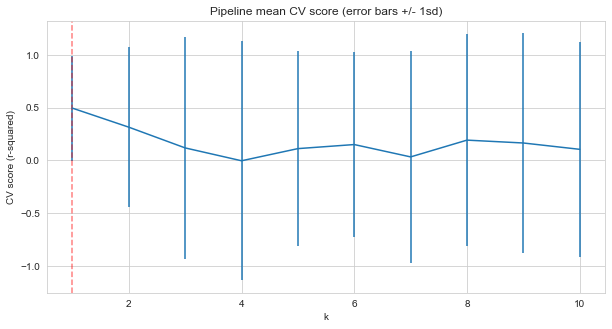

In [22]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_best_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [23]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
selected

array([False,  True, False, False, False, False, False, False, False,
       False])

In [24]:
features = train_columns[selected]

In [25]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
coefs

array([[-4.15216319]])

In [26]:
pd.Series(coefs[0], index=features)

avg_discount_state   -4.152163
dtype: float64

In [45]:
pipe_new = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=1),
    LinearRegression()
)

In [46]:
pipe_new.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=1,
                             score_func=<function f_regression at 0x00000179A6C82D38>)),
                ('linearregression', LinearRegression())])

In [47]:
y_tr_pred = pipe_new.predict(X_train)
y_te_pred = pipe_new.predict(X_test)

In [48]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.7933112208349455, 0.8701692839028163)

In [49]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(1.5550534112056853, 1.3724914622315285)

### Random forest regressor

In [32]:
# pipeline
rf_pipe = make_pipeline(   
    StandardScaler(), #SimpleImputer(strategy='median'),
    RandomForestRegressor(random_state=42)
)

In [36]:
rf_cv_results = cross_validate(rf_pipe, X_train, y_train, cv=5)
rf_cv_results

{'fit_time': array([0.14576173, 0.07994628, 0.07692432, 0.07670307, 0.0799334 ]),
 'score_time': array([0.00897026, 0.00598407, 0.00594425, 0.00595093, 0.00597882]),
 'test_score': array([ 0.41286212,  0.67123477,  0.89569581,  0.79267699, -0.15046356])}

In [44]:
np.mean(rf_cv_results['test_score']), np.std(rf_cv_results['test_score'])

(0.524401223895922, 0.37397195013054757)

### Data Quantity Assessment

In [28]:
# Would more data be useful?  Assess this trade off by seeing how performance varies with differing data set sizes.
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(RF_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

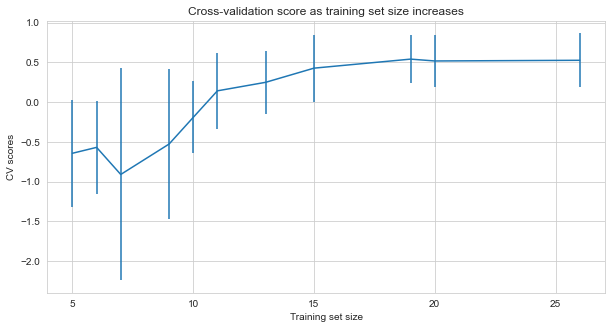

In [29]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 500-600.  This shows that we seem to have plenty of data. 

### Save Final Model

In [30]:
final_model = rf_grid_cv.best_estimator_
final_model.version = '1.0'
final_model.pandas_version = pd.__version__
final_model.numpy_version = np.__version__
final_model.sklearn_version = sklearn_version
final_model.build_datetime = datetime.datetime.now()

# save the model

modelpath = '../models'
save_file(final_model, 'customer_analysis_model.pkl', modelpath)

NameError: name 'rf_grid_cv' is not defined

## Summary and further analysis

- To solve this binary classification problem, I trained 5 different supervised machine learning models. After comparing and evaluating the model performance, the final random forest model is selected and applied to predict customers' response to the last marketing champaign. 
- The final random forest model has the average accuracy of 0.88 and a strong roc_auc of 0.85, which is consistent with cross validation roc of 0.83. The random forest model is fast to train, easy to tune and not prone to overfitting.
- The analysis of customers' family structures, income and spending behaviors can help business better plan marketing strategies, boost new customer enrollment and potentially increase revenue. Further analysis which features contribute most to customers' total expenses may generate more insights from the data.